In [1]:
# reload modules before executing code so we can modify modules and test without restarting kernel
%load_ext autoreload
%autoreload 2

import sys
import warnings
sys.path.append('..')
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

import run as run
from models import *
import utils

ModuleNotFoundError: No module named 'seaborn'

#### 1. Load the EGO model and initialize its parameters.

In [1]:
from PIL import Image
# Display the EGO model architecture
model_image = Image.open('ego_model.png')
display(model_image)

FileNotFoundError: [Errno 2] No such file or directory: 'ego_model.png'

In [2]:
def prep_recurrent_network(rnet, state_d, persistance=-0.6):
    '''Prepare a recurrent context module that functions as a leaky integrator of the input state.
    '''
    with torch.no_grad():
        # Most weights/biases are set to zero or identity matrices here, except for the learnable output from context to EM.
        rnet.state_to_hidden.weight.copy_(torch.eye(state_d, dtype=torch.float))
        rnet.state_to_hidden.bias.zero_()
        rnet.hidden_to_hidden.weight.zero_()
        rnet.hidden_to_hidden.bias.zero_()
        rnet.state_to_hidden_wt.weight.zero_()
        # Set the integration constant (not exactly a leaky integrator, but close enough)
        rnet.state_to_hidden_wt.bias.copy_(torch.ones((len(rnet.state_to_hidden_wt.bias),), dtype=torch.float) * persistance)
        rnet.hidden_to_hidden_wt.weight.zero_()
        rnet.hidden_to_hidden_wt.bias.zero_()
        # Set hidden to context weights as an identity matrix.
        rnet.hidden_to_context.weight.copy_(torch.eye(state_d, dtype=torch.float))
        rnet.hidden_to_context.bias.zero_()

    # Set requires_grad to True for hidden_to_context.weight before freezing other parameters
    rnet.hidden_to_context.weight.requires_grad = True
    rnet.hidden_to_context.bias.requires_grad = True

    # Freeze recurrent weights to stabilize training
    for name, p in rnet.named_parameters():
        if 'hidden_to_context' not in name:
            p.requires_grad = False
        else:
            p.requires_grad = True
    return rnet

# Hyperparameters for the CSW experiments.
softmax_temperature = 0.1
state_d = 11    # dimensionality of the input state vector
context_d = 11  # dimensionality of the context vector (should be the same as the state vector for these experiments)
persistance = -0.8  # how much of the incoming state information is integrated into the context

# Initialize the recurrent context module.
context_module = RecurrentContextModule(state_d, state_d, context_d)
em_module = EMModule(softmax_temperature)
context_module = prep_recurrent_network(context_module, state_d, persistance)
print(context_module)

NameError: name 'RecurrentContextModule' is not defined

#### 2. Generate some toy data for the CSW task.

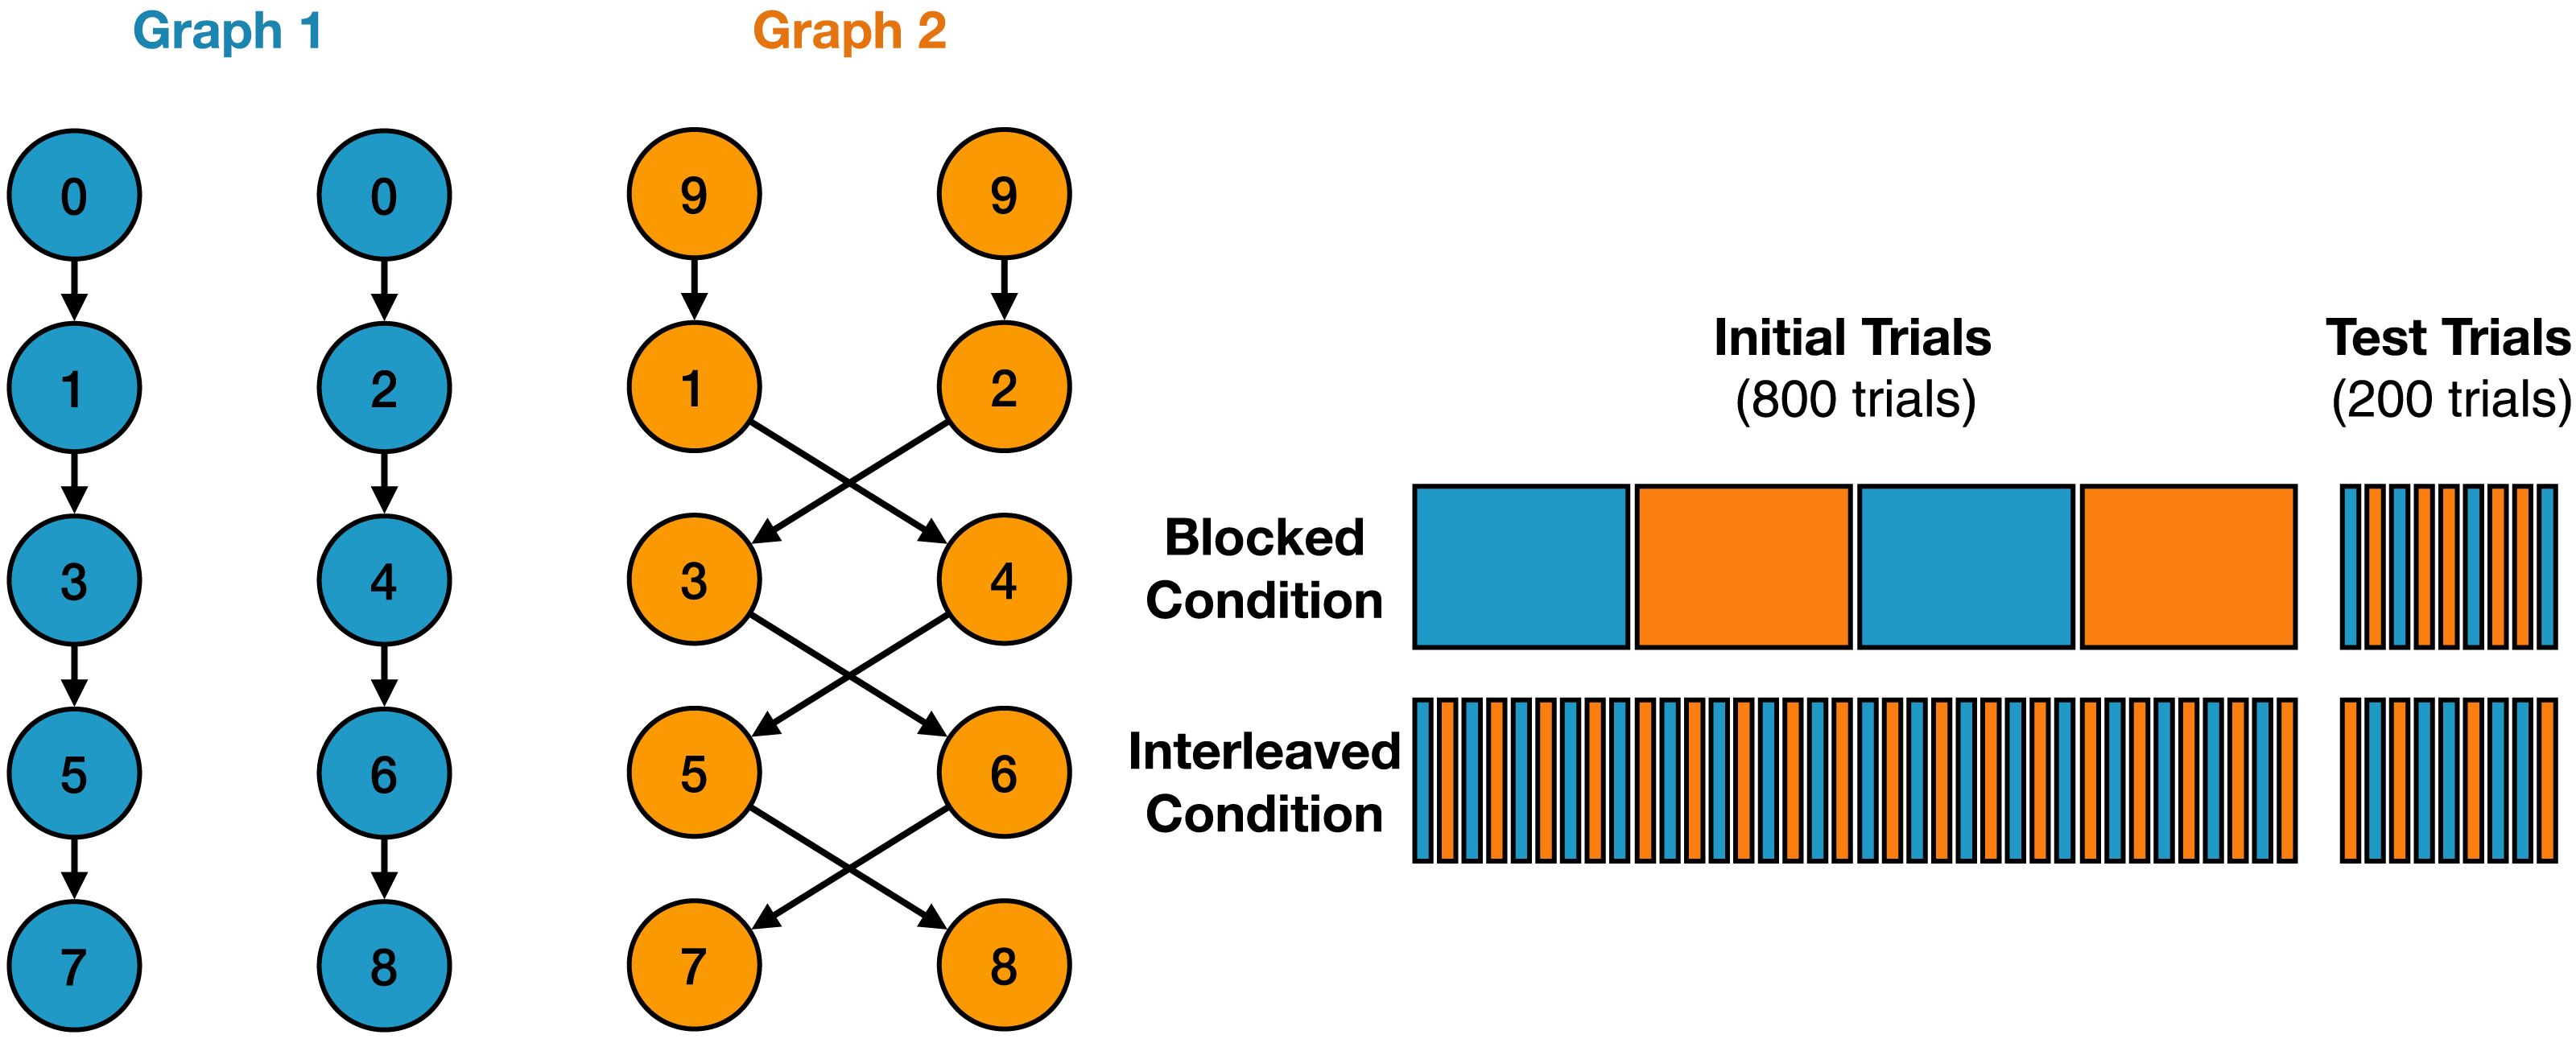

In [32]:
csw_img = Image.open('csw.png')
display(csw_img)

Text(0, 0.5, 'Time')

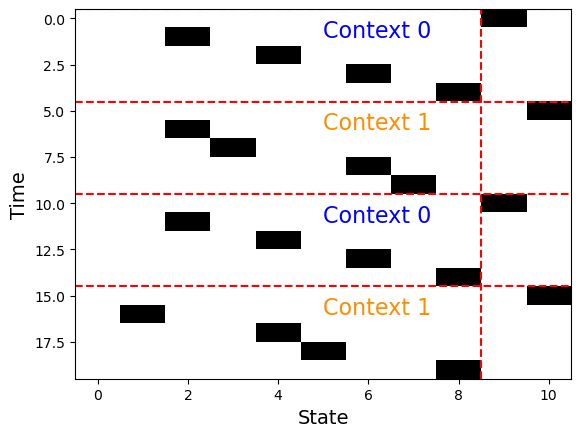

In [114]:
from random import randint
from datasets import CSWDataset

probs = [1, 1, 1] # Probability of the context appropriate transition for the 2nd-4th state. Deterministic for now.
contexts_to_load = [0,1,0,1,0]      # indices of the contexts for each trial (5 states per trial)
n_samples_per_context = [1,1,1,1,1] # number of times to visit each context before transitioning
ds = CSWDataset(n_samples_per_context, contexts_to_load, probs=probs)

# Plot some example data from the CSW task.
plt.imshow(ds.xs[:20], cmap='Greys', aspect='auto')
for i, x in enumerate(np.linspace(0, 15, 4)):
    plt.axhline(x-0.5, color='red', linestyle='--')
    if i%2 == 0:
        plt.text(5, x+1, 'Context 0', fontsize=16, color='blue')
    else:
        plt.text(5, x+1, 'Context 1', fontsize=16, color='darkorange')
plt.axvline(8.5, color='red', linestyle='--')
plt.xlabel('State', fontsize=14)
plt.ylabel('Time', fontsize=14)

In [98]:
from run import gen_data_loader, gen_model

def calc_prob(em_preds, test_ys):
    '''Calculate the probability of the EM model predicting the correct state through EM retrieval.
    '''
    # Only consider the terminal three states (they are the only predictable transitions).
    em_preds_new, test_ys_new = em_preds[:, 2:-1, :], test_ys[:, 2:-1, :]
    em_probability = (em_preds_new*test_ys_new).sum(-1).mean(-1)
    trial_probs = (em_preds*test_ys)
    return em_probability, trial_probs

def run_participant(params, training_paradigm):
    performance_data = {'seed':[], 'paradigm':[], 'trial':[], 'probability':[]}
    loss_fn = nn.BCELoss()
    data_loader = gen_data_loader(training_paradigm, params['probs'])
    context_module, em_module = gen_model(params)
    optimizer = torch.optim.SGD(lr=params.episodic_lr, params=context_module.parameters())
    em_preds = []
    utils.set_random_seed(params.seed)
    for trial, (x,_,y) in enumerate(data_loader):
        for _ in range(params['n_optimization_steps']):
            context = context_module(x)
            if trial > 0:
                optimizer.zero_grad()
                pred_em = em_module(x,context)
                loss = loss_fn(pred_em,y)
                loss.backward()
                optimizer.step()
            else:
                pred_em = torch.zeros([1,params.output_d]).float()
        with torch.no_grad():
            em_module.write(x,context,y)
            em_preds.append(pred_em.cpu().detach().numpy())

    # Collect some metrics from the training run for analysis.
    em_preds = np.stack(em_preds).squeeze()
    em_preds = np.vstack([em_preds, np.zeros([1,11])]).reshape(-1,5,11)
    test_ys = np.vstack([data_loader.dataset.ys.cpu().numpy(), np.zeros([1,11])]).reshape(-1,5,11)
    correct_prob, _ = calc_prob(em_preds, test_ys)
    performance_data['probability'].extend(correct_prob)
    performance_data['seed'].extend([params.seed]*len(correct_prob))
    performance_data['paradigm'].extend([training_paradigm]*len(correct_prob))
    performance_data['trial'].extend(list(range(len(correct_prob))))
    return pd.DataFrame(performance_data)

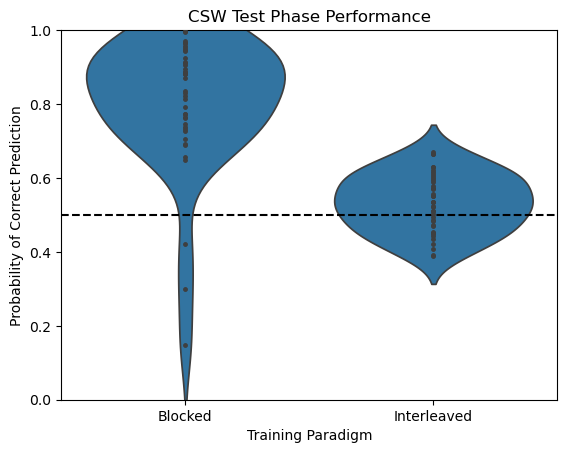

In [100]:
# Set up the parameters for the experiment.
params = utils.Map(
    n_participants = 1,
    state_d = 11, # dimensionality of the state input
    context_d = 11, # dimensionality of the learned context representations
    output_d = 11, # dimensionality of the output layer
    episodic_lr = 1, # learning rate for the episodic pathway
    persistance = -0.8, # bias towards memory retention in the recurrent context module
    temperature = 0.1, # temperature for EM retrieval (lower is more argmax-like)
    n_optimization_steps = 10, # number of optimization steps to take for each state
    probs = [1, 1, 1], # probability of the context appropriate transition for the 2nd-4th state
    seed = 0 # random seed for reproducibility
)

# Run a single participant through the CSW task using the Blocked paradigm.
blocked_results = run_participant(params, 'Blocked')
interleaved_results = run_participant(params, 'Interleaved')

# Plot the performance of the model on the CSW task during the test phase
results_df = pd.concat([blocked_results, interleaved_results])
test_phase = results_df[results_df.trial >=160]
sns.violinplot(data=test_phase, x='paradigm', y='probability', inner='point', scale='count')
plt.ylim(0,1)
plt.ylabel('Probability of Correct Prediction')
plt.xlabel('Training Paradigm')
plt.title('CSW Test Phase Performance')
plt.axhline(0.5, color='black', linestyle='--')

#### 4. Put it all together!

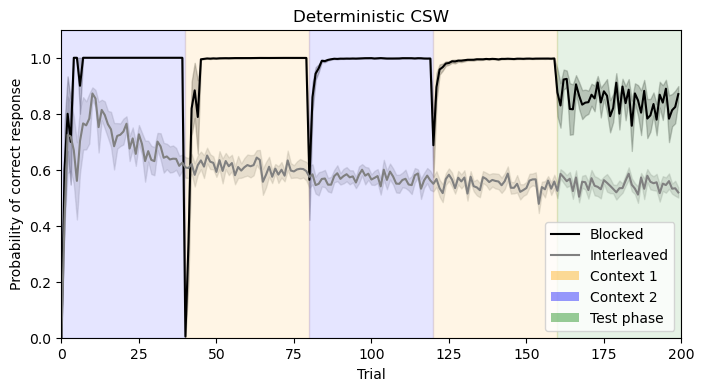

In [115]:
# Set up the parameters for the experiment.
params.n_participants = 10
params.paradigms = ['Blocked', 'Interleaved']
params.sim_thresh = 0.1  # filtering criterion that will be useful later.
df, _, context_reps, _ = run.run_experiment(params)
fig = utils.plot_results(df, 'Deterministic CSW')
fig.show()